# Causal CelebA VAE with Causal NF results

In [ ]:
%load_ext autoreload
%autoreload 2

In [69]:
import os
import re
from copy import copy
from pathlib import Path
from pprint import pprint

import lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, random_split
import normflows as nf
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import seaborn as sns
import matplotlib.pyplot as plt

from ciflows.datasets.causalceleba import CausalCelebA
from ciflows.datasets.multidistr import StratifiedSampler
from ciflows.datasets.causalceleba import CausalCelebAEmbedding
from ciflows.datasets.multidistr import StratifiedSampler
from ciflows.distributions.pgm import LinearGaussianDag
from ciflows.eval import load_model
from ciflows.flows.model import CausalNormalizingFlow
from ciflows.reduction.vae import VAE
from ciflows.reduction.resnetvae import DeepResNetVAE

In [144]:
def make_nf_model(debug=False):
    """Make normalizing flow model."""
    # Define list of flows
    if debug:
        K = 2
        net_hidden_layers = 2
        net_hidden_dim = 64
    else:
        K = 32
        K = 8
        net_hidden_layers = 3
        net_hidden_dim = 64

    latent_dim = 48

    flows = []
    for i in range(K):
        flows += [
            nf.flows.AutoregressiveRationalQuadraticSpline(
                latent_dim, net_hidden_layers, net_hidden_dim
            )
        ]

    node_dimensions = {
        0: 16,
        1: 16,
        2: 16,
    }
    edge_list = [(1, 2)]
    noise_means = {
        0: torch.zeros(16),
        1: torch.zeros(16),
        2: torch.zeros(16),
    }
    noise_variances = {
        0: torch.ones(16),
        1: torch.ones(16),
        2: torch.ones(16),
    }
    intervened_node_means = [{2: torch.ones(16) + 2}, {2: torch.ones(16) + 4}]
    intervened_node_vars = [{2: torch.ones(16)}, {2: torch.ones(16) + 2}]

    confounded_list = []
    # independent noise with causal prior
    q0 = LinearGaussianDag(
        node_dimensions=node_dimensions,
        edge_list=edge_list,
        noise_means=noise_means,
        noise_variances=noise_variances,
        confounded_list=confounded_list,
        intervened_node_means=intervened_node_means,
        intervened_node_vars=intervened_node_vars,
    )

    # Construct flow model with the multiscale architecture
    model = CausalNormalizingFlow(q0, flows)
    return model



In [12]:
root = Path("/Users/adam2392/pytorch_data/")
seed_offset = 1

# set seed
seed = 1234
np.random.seed(seed + seed_offset)
pl.seed_everything(seed + seed_offset, workers=True)

image_size = 128
latent_dim = 48
num_blocks_per_stage = 3
debug = False

if torch.cuda.is_available():
    device = torch.device("cuda")
    accelerator = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    accelerator = "mps"
else:
    device = torch.device("cpu")
    accelerator = "cpu"

print(f"Using device: {device}")
print(f"Using accelerator: {accelerator}")

Seed set to 1235


Using device: mps
Using accelerator: mps


In [145]:
# v1: K=32
# v2: K=8
# v3: K=8, batch higher
model_fname = "celeba_nfon_resnetvaereduction_batch256_latentdim48_v1.pt"

# checkpoint_dir = root / "CausalCelebA" / "vae_reduction" / "latentdim24"
checkpoint_dir = (
    root / "CausalCelebA" / "nf_on_vae_reduction" / model_fname.split(".")[0]
)
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# vae_dir = root / "CausalCelebA" / "vae_reduction" / "latentdim48"
# vae_model_fname = "model_epoch_100.pt"
vae_model_fname = "celeba_vaeresnetreduction_batch512_latentdim48_img128_v1.pt"
vae_dir = root / "CausalCelebA" / "vae_reduction" / vae_model_fname.split(".")[0]
# vae_model = VAE().to(device)
vae_model = DeepResNetVAE(latent_dim, num_blocks_per_stage=num_blocks_per_stage)
model_path = vae_dir / vae_model_fname
vae_model = load_model(vae_model, model_path, device)
vae_model = vae_model.to(device)

model = make_nf_model(debug=debug)
# model = torch.compile(model)
state_dict = torch.load(checkpoint_dir / model_fname, map_location=device)
print(state_dict.keys())
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
# model = load_model(model, , device)
model = model.to(device)
image_dim = 3 * image_size * image_size


Model loaded from /Users/adam2392/pytorch_data/CausalCelebA/vae_reduction/celeba_vaeresnetreduction_batch512_latentdim48_img128_v1/celeba_vaeresnetreduction_batch512_latentdim48_img128_v1.pt


/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_50168/1616518734.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_dir / mod

odict_keys(['_orig_mod.q0.exog_mean_0_0', '_orig_mod.q0.exog_variance_0_0', '_orig_mod.q0.exog_mean_1_0', '_orig_mod.q0.exog_variance_1_0', '_orig_mod.q0.exog_mean_2_0', '_orig_mod.q0.exog_variance_2_0', '_orig_mod.q0.exog_mean_2_1', '_orig_mod.q0.exog_variance_2_1', '_orig_mod.q0.exog_mean_2_2', '_orig_mod.q0.exog_variance_2_2', '_orig_mod.q0.edge_weights.1->2', '_orig_mod.flows.0.mprqat.autoregressive_net.initial_layer.weight', '_orig_mod.flows.0.mprqat.autoregressive_net.initial_layer.bias', '_orig_mod.flows.0.mprqat.autoregressive_net.initial_layer.mask', '_orig_mod.flows.0.mprqat.autoregressive_net.initial_layer.degrees', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.0.linear_layers.0.weight', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.0.linear_layers.0.bias', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.0.linear_layers.0.mask', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.0.linear_layers.0.degrees', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.

In [146]:
# load batch of the dataset from observed data
def data_loader(
    root_dir,
    graph_type="chain",
    num_workers=4,
    batch_size=32,
    img_size = 128
):
    # Define the image transformations
    image_transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),  # Resize images to 128x128
            transforms.CenterCrop(img_size),  # Ensure square crop
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    causal_celeba_dataset = CausalCelebA(
        root=root_dir,
        graph_type=graph_type,
        transform=image_transform,
        img_size=img_size,
        fast_dev_run=False,  # Set to True for debugging
    )

    # Calculate the number of samples for training and validation
    # total_len = len(causal_celeba_dataset)
    # val_len = int(total_len * val_split)
    # train_len = total_len - val_len

    # # Split the dataset into train and validation sets
    # train_dataset, val_dataset = random_split(causal_celeba_dataset, [train_len, val_len])

    distr_labels = [x[1] for x in causal_celeba_dataset]
    unique_distrs = len(np.unique(distr_labels))
    if batch_size < unique_distrs:
        raise ValueError(
            f"Batch size must be at least {unique_distrs} for stratified sampling."
        )
    train_sampler = StratifiedSampler(distr_labels, batch_size)

    # Define the DataLoader
    train_loader = DataLoader(
        dataset=causal_celeba_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        drop_last=True,
        # shuffle=True,  # Shuffle data during training
        num_workers=num_workers,
        pin_memory=True,  # Enable if using a GPU
        persistent_workers=True,
    )

    return train_loader

In [135]:
graph_type = 'chain'
num_workers = 2
batch_size = 16
img_size = 128

loader = data_loader(
        root_dir=root,
        graph_type=graph_type,
        num_workers=num_workers,
        batch_size=batch_size,
        img_size=img_size,
    )

Processing intervention type: Haircolor


In [136]:
data_iter = iter(loader)

batch_imgs, distr_idx, targets, meta_labels = next(data_iter)
print(batch_imgs.shape)

torch.Size([16, 3, 128, 128])


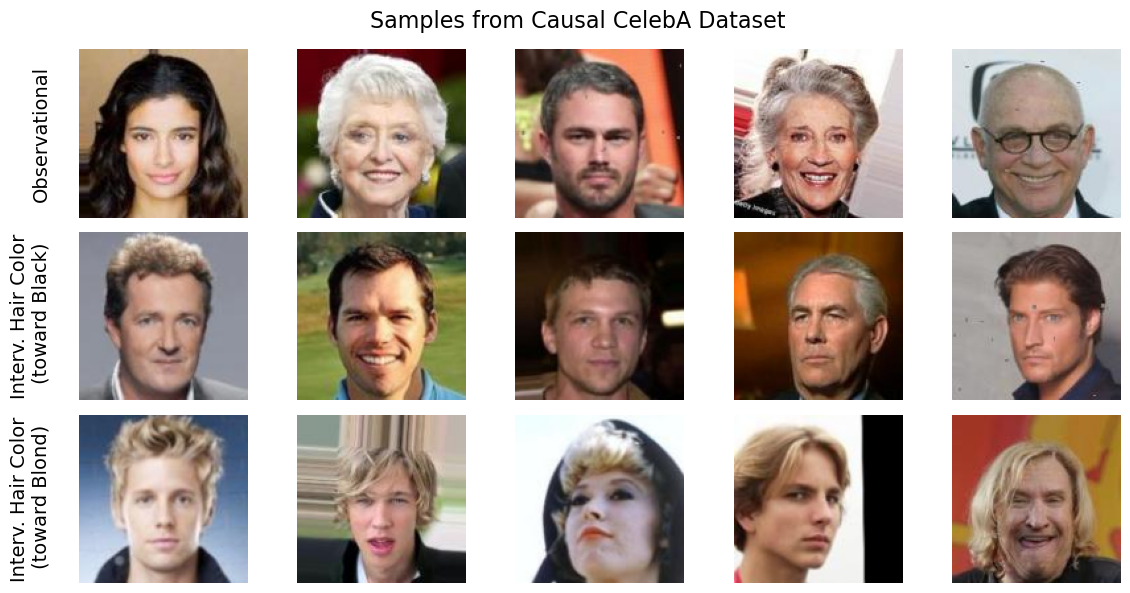

In [110]:
# show images per distribution index
# Helper function to plot images in a row
def plot_images(images, title, n_images=5, axes=None):
    # fig, axes = plt.subplots(1, n_images, figsize=(15, 3))
    # fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes):
        if i < len(images):
            img = images[i].permute(1, 2, 0)  # Change shape from (C, H, W) -> (H, W, C)
            img = img.clamp(0, 1)  # Ensure pixel values are between 0 and 1
            ax.imshow(img)
            # ax.axis("off")
            # Remove ticks and spines but keep the ylabel
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

        
        # Add the y-label only to the leftmost subplot
        axes[0].set_ylabel(title, fontsize=14, rotation=90, labelpad=20)
    # plt.show()

# Extract images based on distr_idx
indices_0 = (distr_idx == 0).nonzero(as_tuple=True)[0]
indices_1 = (distr_idx == 1).nonzero(as_tuple=True)[0]
indices_2 = (distr_idx == 2).nonzero(as_tuple=True)[0]

# Get images for each distribution index
imgs_0 = batch_imgs[indices_0]
imgs_1 = batch_imgs[indices_1]
imgs_2 = batch_imgs[indices_2]

sns.set_context('paper')
fig, axes = plt.subplots(3, 5, figsize=2*np.array([6, 3]))
fig.subplots_adjust(wspace=0)  # Remove spacing between subplots
    
# fig.suptitle(title, fontsize=16)

# Plot the first few images for each distribution index
plot_images(imgs_0, 
            "Observational", 
            n_images=5, axes=axes[0][:])
plot_images(imgs_1, "Interv. Hair Color\n (toward Black)", n_images=5, axes=axes[1][:])
plot_images(imgs_2, "Interv. Hair Color\n (toward Blond)", n_images=5, axes=axes[2])

fig.suptitle("Samples from Causal CelebA Dataset", fontsize=16)
fig.tight_layout()

In [147]:
# map this batch to VAE latent space
batch_imgs = batch_imgs.to(device)
encoded_rep = vae_model.encoder(batch_imgs)
print(encoded_rep.shape)

torch.Size([16, 48])


In [148]:
# map VAe latent space to a causal space and apply intervention on hair color
print(encoded_rep.shape)
causal_rep = model.inverse(encoded_rep)

print(causal_rep.shape)

# apply intervention
print(causal_rep[:, :-16].shape)
causal_rep[:, 32:48] = causal_rep[:, 32:48] + torch.rand(size=(batch_size, 16)).to(device) * 5
print(causal_rep.shape)

torch.Size([16, 48])
torch.Size([16, 48])
torch.Size([16, 32])
torch.Size([16, 48])


In [149]:
# map back to VAE latent space, and then back to image space
recon_rep = model.forward(causal_rep)
reconstructed_imgs = vae_model.decode(recon_rep)

print(recon_rep.shape, reconstructed_imgs.shape)

torch.Size([16, 48]) torch.Size([16, 3, 128, 128])


torch.Size([16, 48]) torch.Size([16, 3, 128, 128])


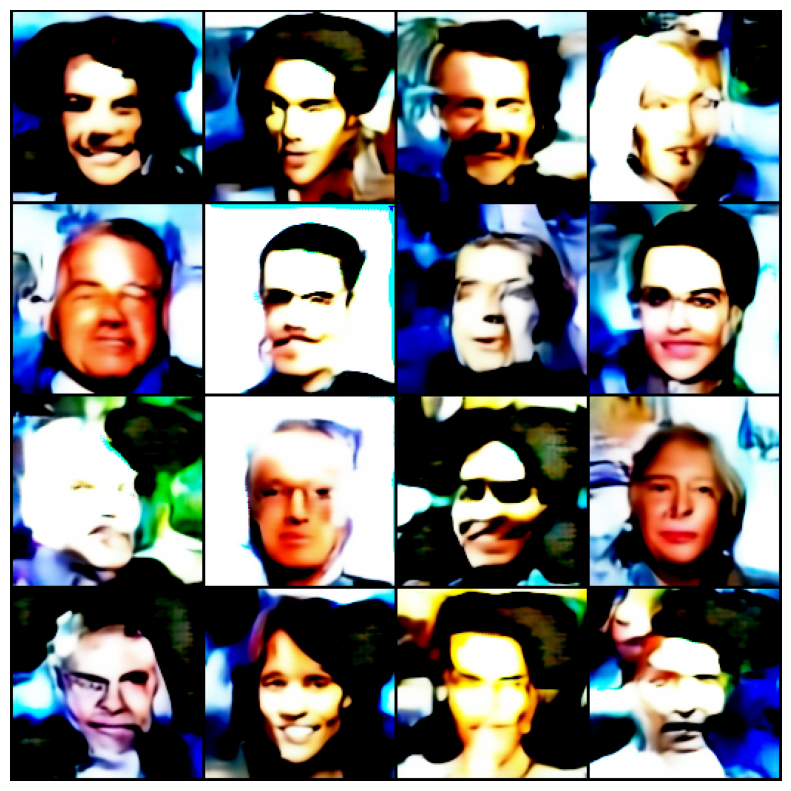

In [150]:
print(recon_rep.shape, reconstructed_imgs.shape)

# plot the images
grid = make_grid(reconstructed_imgs, nrow=4, normalize=True, value_range=(0, 1))  # Normalizes images to [0, 1]

# Option 1: Save the grid to a file
save_image(grid, "image_grid.png")

# Option 2: Display the grid using matplotlib
def tensor_to_numpy(image_tensor):
    # Convert from tensor to NumPy for plotting
    image = image_tensor.cpu().permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    return image.numpy()

# Convert the grid to a NumPy array and display
grid_np = tensor_to_numpy(grid)
plt.figure(figsize=(8, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.show()


torch.Size([16, 48]) torch.Size([16, 3, 128, 128])


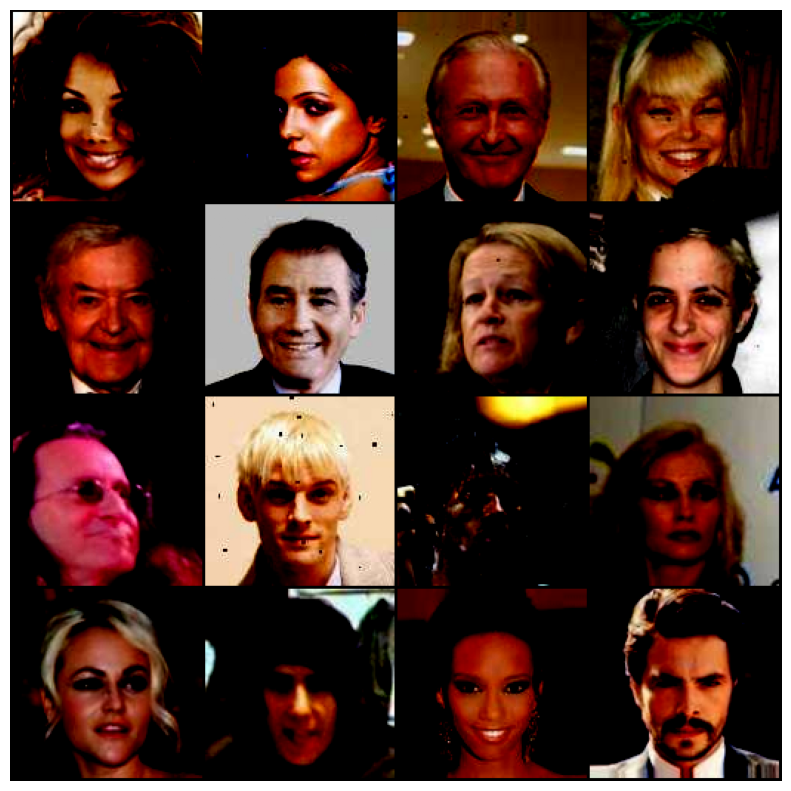

In [151]:
print(recon_rep.shape, reconstructed_imgs.shape)

# plot the images
grid = make_grid(batch_imgs, nrow=4, normalize=True, value_range=(0, 1))  # Normalizes images to [0, 1]

# Option 1: Save the grid to a file
save_image(grid, "image_grid.png")

# Option 2: Display the grid using matplotlib
def tensor_to_numpy(image_tensor):
    # Convert from tensor to NumPy for plotting
    image = image_tensor.cpu().permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    return image.numpy()

# Convert the grid to a NumPy array and display
grid_np = tensor_to_numpy(grid)
plt.figure(figsize=(8, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.show()


torch.Size([16, 48])


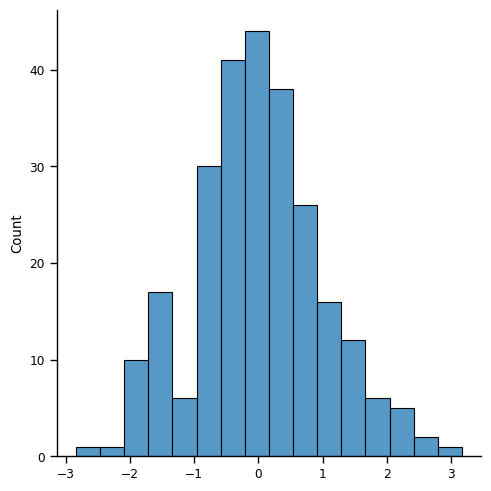

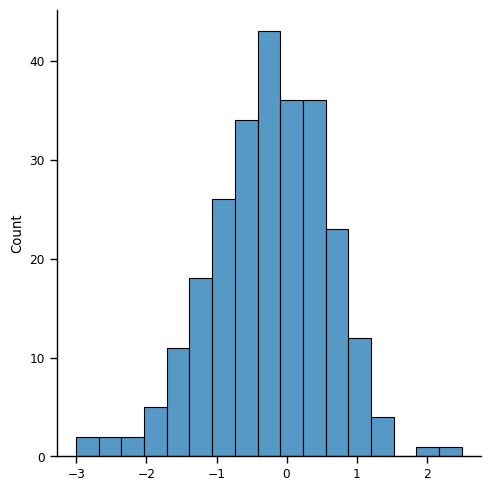

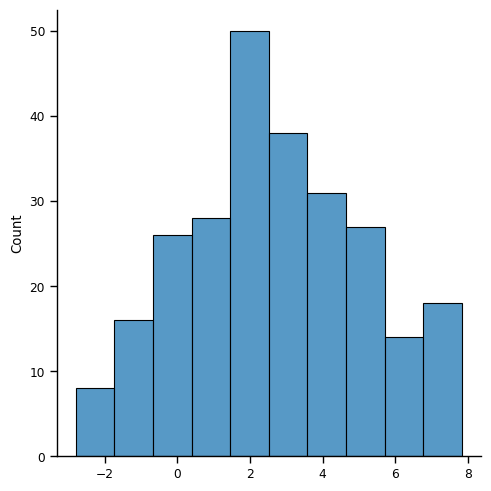

In [142]:
# evaluate the model and its output in latent space
print(causal_rep.shape)

# plot this
sns.displot(causal_rep.cpu().detach().numpy()[:, :16].flatten(), label='Gender')
sns.displot(causal_rep.cpu().detach().numpy()[:, 16:32].flatten(), label='Age')
sns.displot(causal_rep.cpu().detach().numpy()[:, 32:48].flatten(), label='Hair Color')